### Importing Libraries and Modules for U-Net Model in TensorFlow

This code imports the necessary libraries and modules to build and train a U-Net model in TensorFlow, specifically for working with spatial data such as images or geospatial datasets.

- `from tensorflow import keras`: Imports 𝑘𝑒𝑟𝑎𝑠 from 𝑇𝑒𝑛𝑠𝑜𝑟𝐹𝑙𝑜𝑤 for building deep learning models.

- `import tensorflow as tf`: Imports the 𝑇𝑒𝑛𝑠𝑜𝑟𝐹𝑙𝑜𝑤 library, which provides a range of tools for deep learning and tensor-based computation.

- `from keras.layers import (Activation, BatchNormalization, Concatenate, Conv2D, Conv2DTranspose, Input, MaxPool2D)`:
   - Imports essential 𝐾𝑒𝑟𝑎𝑠 𝑙𝑎𝑦𝑒𝑟𝑠 for building a 𝑈-𝑁𝑒𝑡 architecture:
     - `Activation`: Adds an activation function to a layer.
     - `BatchNormalization`: Normalizes activations in each layer to stabilize training.
     - `Concatenate`: Merges multiple input tensors along a specified axis.
     - `Conv2D`: Applies a 2D convolution, useful for extracting spatial features.
     - `Conv2DTranspose`: Performs transposed convolution (deconvolution), used for upsampling in the U-Net decoder.
     - `Input`: Specifies the input shape of the model.
     - `MaxPool2D`: Applies a 2D max pooling operation to reduce spatial dimensions.

- `from keras.models import Model`: Imports 𝑀𝑜𝑑𝑒𝑙 from 𝐾𝑒𝑟𝑎𝑠, which is used to define the U-Net model architecture.

- `import keras.utils as ku`: Imports 𝐾𝑒𝑟𝑎𝑠 𝑢𝑡𝑖𝑙𝑖𝑡𝑖𝑒𝑠 as 𝑘𝑢, which provides helpful functions such as one-hot encoding.

- `from keras.optimizers import Adam`: Imports the 𝐴𝑑𝑎𝑚 optimizer, a popular optimization algorithm used to minimize the model’s loss function and improve performance.



In [3]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import xarray as xr
import tensorflow as tf 
# all the layers used for U-net
from keras.layers import (Activation, BatchNormalization, Concatenate, Conv2D,
                                     Conv2DTranspose, Input, MaxPool2D)
from keras.models import Model
import keras.utils as ku
from keras.optimizers import Adam
import sys


### Loading, Normalizing, and Preparing Data for U-Net Model

1. **Load Datasets**

   - `ename = 'north_nagoya'`: Defines the base name of the dataset region.
   - `dtrain0 = xr.open_dataset('data/'+ename+'_train.nc')`: Loads the training dataset from a NetCDF file.
   - `dval0 = xr.open_dataset('data/'+ename+'_val.nc')`: Loads the validation dataset from a NetCDF file.
   - `dtest0 = xr.open_dataset('data/'+ename+'_test.nc')`: Loads the test dataset from a NetCDF file.

2. **Normalize Data Function**

   - `def datnorm(d)`: Defines a function, `datnorm`, to normalize data by subtracting the mean and dividing by the standard deviation.
   - `return (d - d.mean()) / d.std()`: Returns the normalized dataset to ensure data values are centered around zero with a standard deviation of one.

3. **Apply Normalization to Datasets**

   - `dtrain, dval, dtest = datnorm(dtrain0), datnorm(dval0), datnorm(dtest0)`: Normalizes the training, validation, and test datasets using the `datnorm` function.

4. **Prepare Training Data**

   - `int_data = dtrain['lo'].values`: Extracts the low-resolution values from the normalized training dataset.
   - `X_train = np.expand_dims(int_data, 3)`: Expands the dimensions of `int_data` to add a channel dimension, making it compatible with input expectations of the U-Net model.
   - `y_train = dtrain['hi'].values`: Extracts the high-resolution values from the training dataset to serve as labels.

5. **Prepare Validation Data**

   - `X_val = np.expand_dims(dval['lo'].values, 3)`: Extracts and reshapes the low-resolution validation data for model input.
   - `y_val = dval['hi'].values`: Extracts the high-resolution values from the validation dataset as labels.

6. **Prepare Test Data**

   - `X_test = np.expand_dims(dtest['lo'].values, 3)`: Extracts and reshapes the low-resolution test data for model input.
   - `y_test = dtest['hi'].values`: Extracts the high-resolution values from the test dataset as labels.



In [6]:
ename = 'north_nagoya'
dtrain0 = xr.open_dataset('data/'+ename+'_train.nc')
dval0 = xr.open_dataset('data/'+ename+'_val.nc')
dtest0 = xr.open_dataset('data/'+ename+'_test.nc')

# normalize data 
def datnorm(d): return (d - d.mean()) / d.std() 

# normalize data
dtrain, dval, dtest = datnorm(dtrain0), datnorm(dval0), datnorm(dtest0)

int_data = dtrain['lo'].values
X_train = np.expand_dims(int_data,3)
y_train = dtrain['hi'].values

X_val = np.expand_dims(dval['lo'].values,3)
y_val = dval['hi'].values

X_test = np.expand_dims(dtest['lo'].values,3)
y_test = dtest['hi'].values


print('Shape of X_train: ', X_train.shape)
print('Shape of y_train: ', y_train.shape)
print('Shape of X_validation: ', X_val.shape)
print('Shape of y_validation: ', y_val.shape)
print('Shape of X_test: ', X_test.shape)
print('Shape of y_test: ', y_test.shape)


Shape of X_train:  (255, 24, 32, 1)
Shape of y_train:  (255, 24, 32)
Shape of X_validation:  (66, 24, 32, 1)
Shape of y_validation:  (66, 24, 32)
Shape of X_test:  (44, 24, 32, 1)
Shape of y_test:  (44, 24, 32)


# U-NET from here

In [8]:
def conv_block(inputs, num_filters: int, kernel: tuple = (3,3), padding: str = "same",
               activation: str = "relu", kernel_init: str = "he_normal", l_batch_normalization: bool = True):

    x = Conv2D(num_filters, kernel, padding=padding, kernel_initializer=kernel_init)(inputs)
    if l_batch_normalization: x = BatchNormalization()(x)
    x = Activation(activation)(x)
    return x

# %%
def conv_block_n(inputs, num_filters, n=2, kernel=(3,3), padding="same", activation="relu", 
                     kernel_init="he_normal", l_batch_normalization=True):
    
    x = conv_block(inputs, num_filters, kernel, padding, activation,kernel_init, l_batch_normalization)
    for i in np.arange(n-1):
        x = conv_block(x, num_filters, kernel, padding, activation,kernel_init, l_batch_normalization)
    
    return x

# %%
def encoder_block(inputs, num_filters, kernel_maxpool: tuple=(2,2), l_large: bool=True):

    if l_large: x = conv_block_n(inputs, num_filters, n=2)
    else: x = conv_block(inputs, num_filters) 
    p = MaxPool2D(kernel_maxpool)(x)
    return x, p

# %%
def decoder_block(inputs, skip_features, num_filters, kernel: tuple=(3,3), strides_up: int=2, padding: str= "same", 
                  activation="relu", kernel_init="he_normal", l_batch_normalization: bool=True):

    x = Conv2DTranspose(num_filters, (strides_up, strides_up), strides=strides_up, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block_n(x, num_filters, 2, kernel, padding, activation, kernel_init, l_batch_normalization)
    
    return x


# %% [markdown]
# ### Define learning rate (need to learn more)

# %%
# define a earning-rate scheduler
def lr_scheduler(epoch, lr):
  if epoch < 5:
    return float(lr)
  elif epoch >= 5:
    return float(lr * tf.math.exp(-0.1))
  #elif epoch >= 30:
  #  return float(lr)

# %%
#plt.plot([ lr_scheduler(e,5*10**(-4) ) for e in range(150)])

# %% [markdown]
# ## BUILDING U-NET HERE


# %%
batch_size = 32
epochs = 150
channels_start=56 
shape_in = X_train.shape[1:]

# %%
# parameters 
callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

# build model    
inputs = Input(shape_in)

""" encoder """
s1, e1 = encoder_block(inputs, channels_start, l_large=True)
s2, e2 = encoder_block(e1, channels_start*2, l_large=False)
s3, e3 = encoder_block(e2, channels_start*4, l_large=False)

""" bridge encoder <-> decoder """
b1 = conv_block(e3, channels_start*8)

""" decoder """
d1 = decoder_block(b1, s3, channels_start*4)
d2 = decoder_block(d1, s2, channels_start*2)
d3 = decoder_block(d2, s1, channels_start)

output_temp = Conv2D(1, (1,1), kernel_initializer="he_normal", name="output_temp")(d3)

unet_model= Model(inputs, output_temp, name="t2m_downscaling_unet")

#ku.plot_model(unet_model, show_shapes=True)

unet_model.compile(optimizer=Adam(learning_rate=5*10**(-4)), loss="mse")

# %% [markdown]
# ## RUN U-NET HERE
#
# It will take a while to train model

# %%

if 1: 
    history = unet_model.fit(x=X_train, 
                             y=y_train, 
                             batch_size=batch_size,
                             epochs=epochs, 
                             callbacks=[callback],
                             validation_data=(X_val, y_val ),
                             verbose = 1 # dont show ====== if want to show =1
                             )
    # save model to ecmwf
    unet_model.save('test_small.keras')
    
    print('Finished run')

# %% [markdown]
# ## Predict and verification

# %%
unet_model.summary()

Epoch 1/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 286ms/step - loss: 0.6860 - val_loss: 1.1854 - learning_rate: 5.0000e-04
Epoch 2/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - loss: 0.1461 - val_loss: 0.7811 - learning_rate: 5.0000e-04
Epoch 3/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 267ms/step - loss: 0.0859 - val_loss: 0.4070 - learning_rate: 5.0000e-04
Epoch 4/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 268ms/step - loss: 0.1007 - val_loss: 0.3138 - learning_rate: 5.0000e-04
Epoch 5/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 270ms/step - loss: 0.0977 - val_loss: 0.1908 - learning_rate: 5.0000e-04
Epoch 6/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 270ms/step - loss: 0.0629 - val_loss: 0.1507 - learning_rate: 4.5242e-04
Epoch 7/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 272ms/step - loss: 0.0542 - val_loss: 0.1339 - learning_rate: 4.0937e-04
Epoch 8/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 272ms/step - loss: 0.0722 - val_loss: 0.1139 - learning_rate: 3.7041e-04
Epoch 9/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 277ms/step - loss: 0.0405 - val_loss: 0.0945 - learning_

Model: "t2m_downscaling_unet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 24, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 24, 32,    │        560 │ input_layer[0][0] │
│                     │ 56)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 24, 32,    │        224 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 56)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 24, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 56)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 24, 32,    │     28,280 │ activation[0][0]  │
│                     │ 56)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 32,    │        224 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 56)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 24, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 56)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 12, 16,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 56)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 12, 16,    │     56,560 │ max_pooling2d[0]… │
│                     │ 112)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 16,    │        448 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 112)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 12, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 112)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 6, 8, 112) │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 6, 8, 224) │    226,016 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 8, 224) │        896 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 6, 8, 224) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 3, 4, 224) │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 3, 4, 448) │    903,616 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 10,577,117 (40.35 MB)

 Trainable params: 3,524,585 (13.45 MB)

 Non-trainable params: 3,360 (13.12 KB)

 Optimizer params: 7,049,172 (26.89 MB)

### Plotting Training and Validation Loss Curves



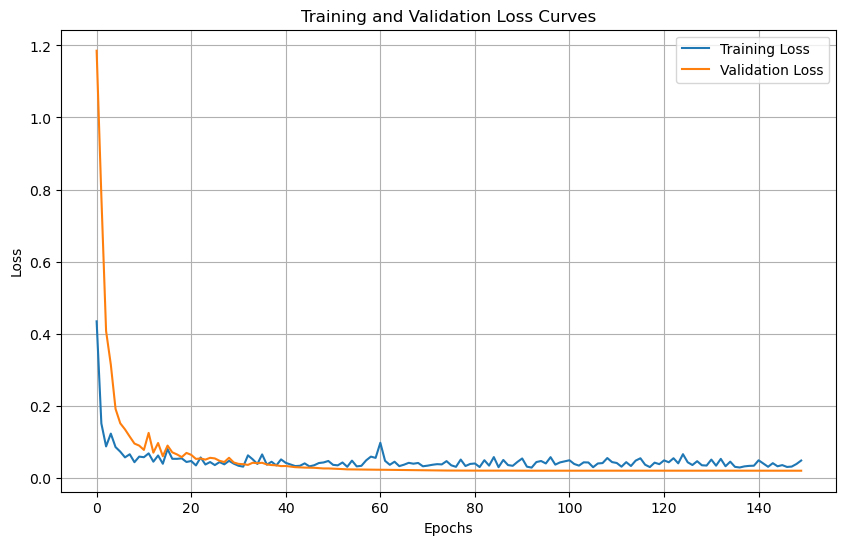

In [9]:
import matplotlib.pyplot as plt
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()


In [20]:
import os
import xarray as xr
import numpy as np
import tensorflow as tf

# Load the model and perform predictions
xmodel = unet_model  # Model can also be loaded from file if needed

# Generate predictions for validation and test datasets
y_pred_val = xmodel.predict(X_val, verbose=1)
y_pred_test = xmodel.predict(X_test, verbose=1)

# Function to revert normalized predictions to the original scale
def revert_to_original_scale(pred, data_mean, data_std):
    return pred * data_std.values + data_mean.values

# Revert predictions to the original scale
y_pred_test_r = revert_to_original_scale(y_pred_test, dtest0.mean()['hi'], dtest0.std()['hi'])
y_pred_val_r = revert_to_original_scale(y_pred_val, dval0.mean()['hi'], dval0.std()['hi'])


# Create datasets for predictions and actual values
def create_dataset(pred_r, data, coord_data):
    ds = xr.Dataset()
    ds['pred'] = (('dat', 'latitude', 'longitude'), pred_r.squeeze())
    ds['real'] = data['hi']
    ds = ds.assign_coords(latitude=coord_data.latitude, longitude=coord_data.longitude)
    return ds

do = create_dataset(y_pred_test_r, dtest0, dtest0)
dv = create_dataset(y_pred_val_r, dval0, dval0)

# Save datasets to NetCDF format
output_dir = 'output/'
os.makedirs(output_dir, exist_ok=True)
do.to_netcdf(output_dir + ename + '_prediction.nc')
dv.to_netcdf(output_dir + ename + '_validation.nc')

do.close()
dv.close()




3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


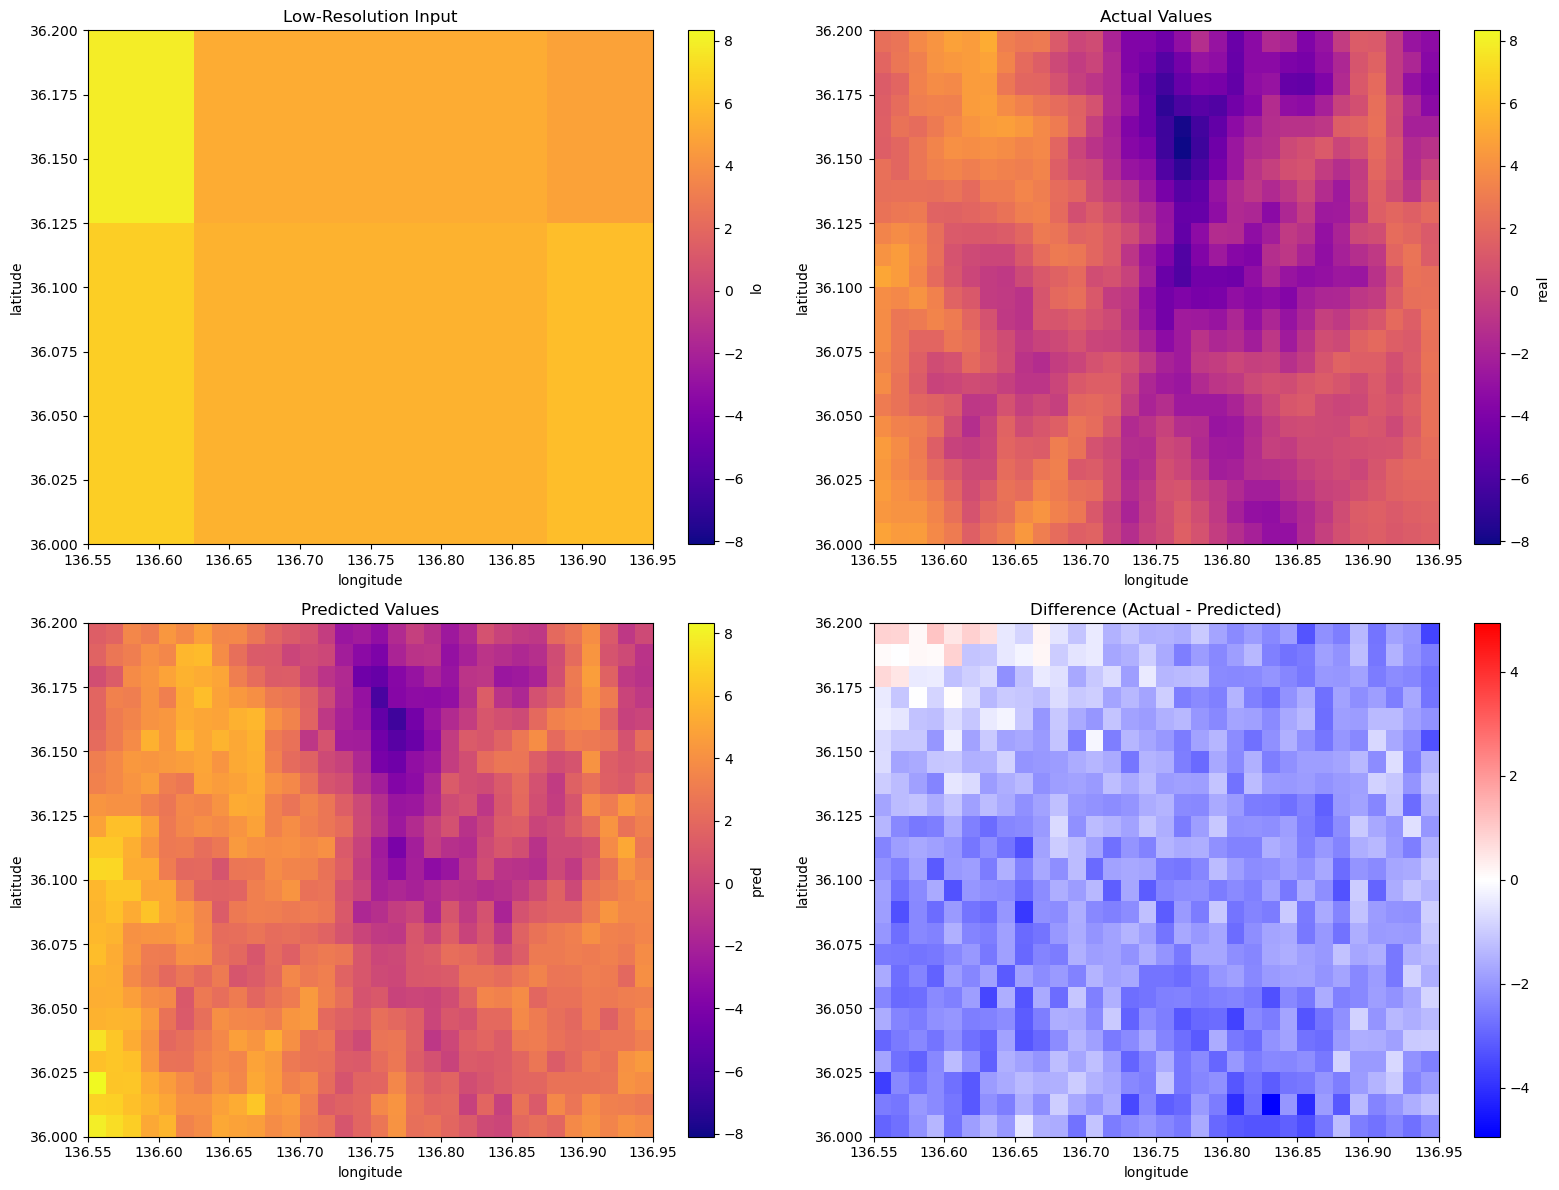

In [21]:
import matplotlib.pyplot as plt

# Calculate the difference between actual and predicted values
difference = do['real'][1] - do['pred'][1]

# Determine the shared color range for the first three panels
vmin = min(dtest0['lo'][1].min(), do['real'][1].min(), do['pred'][1].min())
vmax = max(dtest0['lo'][1].max(), do['real'][1].max(), do['pred'][1].max())

# Create a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot low-resolution input in the first panel (top-left)
dtest0['lo'][1].plot(ax=axes[0, 0], cmap="plasma", vmin=vmin, vmax=vmax)
axes[0, 0].set_title("Low-Resolution Input")

# Plot actual values in the second panel (top-right)
do['real'][1].plot(ax=axes[0, 1], cmap="plasma", vmin=vmin, vmax=vmax)
axes[0, 1].set_title("Actual Values")

# Plot predicted values in the third panel (bottom-left)
do['pred'][1].plot(ax=axes[1, 0], cmap="plasma", vmin=vmin, vmax=vmax)
axes[1, 0].set_title("Predicted Values")

# Plot the difference in the fourth panel (bottom-right) with "bluewhitered" colormap
difference.plot(ax=axes[1, 1], cmap="bwr", center=0)
axes[1, 1].set_title("Difference (Actual - Predicted)")

# Enhance layout and display the plot
plt.tight_layout()
plt.show()
